# Fase 5 – Evaluación y comparación de modelos supervisados

En este cuaderno se evalúan y comparan varios modelos de aprendizaje supervisado para la clasificación binaria de candidatos a exoplanetas del catálogo KOI. A partir del conjunto de datos preprocesado y enriquecido en las fases anteriores, se calculan métricas en los conjuntos de *train*, *validation* y *test*, se selecciona el mejor modelo y se generan figuras que resumen su desempeño (matriz de confusión, curvas ROC y análisis de probabilidades).

El objetivo principal de esta fase es responder, de forma cuantitativa y visual, qué modelo clásico ofrece el mejor compromiso entre precisión, sensibilidad y robustez, y cómo se comporta frente al desbalance de clases y al ruido inherente a los datos astronómicos.


## 5.1 Importación de librerías y configuración general

En esta sección se importan las librerías necesarias para la evaluación de modelos: `pandas` y `numpy` para el manejo de datos, `matplotlib` para la visualización y los módulos de `scikit-learn` para la partición de los datos, la definición de modelos y el cálculo de métricas de desempeño.

También se configura el estilo de las gráficas y algunas opciones de visualización de `pandas`, de modo que los resultados sean más legibles durante el análisis.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", 80)

## 5.2 Carga del conjunto de datos final y distribución de clases

Aquí se carga el conjunto de datos KOI ya limpio y enriquecido, producido en las fases 1–3. Cada fila corresponde a un candidato a exoplaneta etiquetado como `CONFIRMED` o `FALSE_POSITIVE`, junto con el conjunto de características físicas y derivadas seleccionadas en la fase de ingeniería de características.

Se inspecciona la forma de la tabla y se analiza la distribución de la variable objetivo (`is_confirmed`) para cuantificar el grado de desbalance entre exoplanetas confirmados y falsos positivos. Esta información es clave para interpretar correctamente métricas como la *accuracy* y para justificar el uso de métricas adicionales como F1 y AUC.


In [ ]:
df = pd.read_csv("/content/exoplanet_koi_binary_enriched.csv")

print("Shape del dataset enriquecido:", df.shape)
df.head()

Shape del dataset enriquecido: (7585, 51)


,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_srho,koi_prad,koi_incl,koi_teq,koi_insol,koi_dor,koi_ldm_coeff2,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_count,koi_num_transits,koi_tce_plnt_num,koi_bin_oedp_sig,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass,ra,dec,koi_kepmag,koi_fwm_stat_sig,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky,is_confirmed,log_koi_period,log_koi_prad,log_koi_teq,log_koi_insol,log_koi_depth,stellar_density,planet_to_star_radius_ratio
0,1.000,0,0,0,0,9.488036,170.538750,0.146,2.95750,615.8,3.20796,2.26,89.66,793.0,93.59,24.810,0.2291,5.135849,28.470820,35.8,2,142.0,1.0,0.6864,5455.0,4.467,0.14,0.927,0.919,291.93423,48.141651,15.347,0.002,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320,1,2.350235,1.181727,6.677083,4.549552,6.424545,1.153656,0.022326
1,0.969,0,0,0,0,54.418383,162.513840,0.586,4.50700,874.8,3.02368,2.83,89.57,443.0,9.11,77.900,0.2291,7.027669,20.109507,25.8,2,25.0,2.0,0.0023,5455.0,4.467,0.14,0.927,0.919,291.93423,48.141651,15.347,0.003,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500,1,4.014911,1.342865,6.095825,2.313525,6.775138,1.153656,0.027957
2,0.000,0,1,0,0,1.736952,170.307565,1.276,2.40641,8079.2,0.22080,33.46,67.09,1395.0,891.96,3.278,0.2865,39.066550,541.895100,505.6,1,621.0,1.0,0.0000,5805.0,4.564,-0.52,0.791,0.836,285.53461,48.285210,15.597,0.000,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276,0,1.006845,3.539799,7.241366,6.794542,8.997172,1.689183,0.387371
3,1.000,0,0,0,0,2.525592,171.595550,0.701,1.65450,603.3,1.98635,2.75,85.41,1406.0,926.16,8.750,0.2844,4.749945,33.191900,40.9,1,515.0,1.0,0.3090,6031.0,4.438,0.07,1.046,1.095,288.75488,48.226200,15.509,0.733,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070,1,1.260048,1.321756,7.249215,6.832126,6.404071,0.956795,0.024076
4,1.000,0,0,0,0,11.094321,171.201160,0.538,4.59450,1517.5,0.67324,3.90,88.11,835.0,114.81,16.360,0.2889,9.046456,55.204865,66.5,3,95.0,1.0,0.0975,6046.0,4.486,-0.08,0.972,1.053,296.28613,48.224670,15.714,NaN,-0.120,0.140,0.00004,NaN,0.040,-0.070,0.080,-0.020,-0.080,0.080,1,2.492736,1.589235,6.728629,4.751951,7.325478,1.146647,0.036743


In [ ]:
# Revisar la variable objetivo
target_col = "is_confirmed"

df[target_col].value_counts(), df[target_col].value_counts(normalize=True)

(is_confirmed
 0    4839
 1    2746
 Name: count, dtype: int64,
 is_confirmed
 0    0.63797
 1    0.36203
 Name: proportion, dtype: float64)

## 5.3 Selección de características y partición del conjunto de datos

En esta parte se definen explícitamente las variables predictoras (*features*) que se utilizarán para el modelado supervisado, excluyendo identificadores y columnas que podrían actuar como “oráculos” (por ejemplo, `koi_score` y ciertas banderas de falsos positivos). Con esto se garantiza que los modelos se apoyen principalmente en información físico-astronómica.

Posteriormente, el conjunto de datos se divide en tres subconjuntos: *train*, *validation* y *test*, de forma estratificada para preservar la proporción entre exoplanetas confirmados y falsos positivos. El conjunto de *validation* se emplea para ajustar hiperparámetros, mientras que el *test* se reserva para la evaluación final e imparcial de los modelos.


In [ ]:
# Todas las columnas menos la etiqueta
all_features = [c for c in df.columns if c != target_col]

# Columnas "trampa" ligadas directamente a la decisión de la NASA
trampa_cols = ["koi_score", "koi_fpflag_nt", "koi_fpflag_ss", "koi_fpflag_co", "koi_fpflag_ec"]
trampa_cols = [c for c in trampa_cols if c in df.columns]

print("Columnas 'trampa' que se excluyen:", trampa_cols)

# Features físicas / numéricas y variables derivadas que usaremos para el modelo "científico"
feature_cols_phys = [c for c in all_features if c not in trampa_cols]

print("Número de features físicas:", len(feature_cols_phys))
feature_cols_phys[:15]

Columnas 'trampa' que se excluyen: ['koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']
Número de features físicas: 45


['koi_period',
 'koi_time0bk',
 'koi_impact',
 'koi_duration',
 'koi_depth',
 'koi_srho',
 'koi_prad',
 'koi_incl',
 'koi_teq',
 'koi_insol',
 'koi_dor',
 'koi_ldm_coeff2',
 'koi_max_sngle_ev',
 'koi_max_mult_ev',
 'koi_model_snr']

In [ ]:
# Matriz de características (solo físicas) y vector de etiquetas
X = df[feature_cols_phys].copy()
y = df[target_col].astype(int)

# 1) Primero: Train+Val (85%) y Test (15%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.15,
    stratify=y,
    random_state=42
)

# 2) Luego: dentro de Train+Val -> Train (70%) y Val (15%) aprox.
# 70 / 85 ≈ 0.8235  → para que sobre ~15% total para validación
val_size_rel = 0.15 / 0.85  # ≈ 0.1765

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=val_size_rel,
    stratify=y_trainval,
    random_state=42
)

print("Train shape:", X_train.shape, "Proporción positivos:", y_train.mean())
print("Val   shape:", X_val.shape,   "Proporción positivos:", y_val.mean())
print("Test  shape:", X_test.shape,  "Proporción positivos:", y_test.mean())

Train shape: (5309, 45) Proporción positivos: 0.3620267470333396
Val   shape: (1138, 45) Proporción positivos: 0.36203866432337434
Test  shape: (1138, 45) Proporción positivos: 0.36203866432337434


## 5.4 Funciones de evaluación y estructura para almacenar resultados

En esta sección se define una función auxiliar para entrenar y evaluar los modelos en los conjuntos de *train* y *validation*, calculando métricas estándar como *accuracy*, *precision*, *recall*, F1 y AUC.

Además, se inicializan estructuras (`results` y `trained_models`) para almacenar tanto los resultados numéricos de cada modelo como las instancias ya entrenadas. Esto permite, más adelante, comparar fácilmente el desempeño de todos los modelos y reutilizar directamente el mejor de ellos en el conjunto de *test*.


In [ ]:
results = []           # aquí guardamos métricas de todos los modelos
trained_models = {}    # aquí guardamos los modelos ya entrenados (para ROC, interpretabilidad, etc.)

def eval_sklearn_model(name, model,
                       X_tr, y_tr,
                       X_va, y_va,
                       X_te, y_te,
                       results_list,
                       models_dict):
    """
    Evalúa un modelo tipo scikit-learn (Pipeline) en:
    - Train
    - Validación
    - Test

    Calcula: Accuracy, Precision, Recall, F1, AUC
    Muestra matriz de confusión y classification_report para TEST.
    Guarda resultados en results_list y el modelo entrenado en models_dict.
    """
    print("="*70)
    print(name)

    def eval_split(split_name, X, y):
        y_pred = model.predict(X)

        acc  = accuracy_score(y, y_pred)
        prec = precision_score(y, y_pred)
        rec  = recall_score(y, y_pred)
        f1   = f1_score(y, y_pred)

        # Intentamos calcular AUC si el modelo soporta predict_proba
        auc = np.nan
        if hasattr(model, "predict_proba"):
            try:
                y_proba = model.predict_proba(X)[:, 1]
                auc = roc_auc_score(y, y_proba)
            except Exception:
                pass

        print(f"{split_name}: acc={acc:.3f}, prec={prec:.3f}, rec={rec:.3f}, f1={f1:.3f}, auc={auc:.3f}")
        return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "auc": auc}, y_pred

    # Evaluar en cada subset
    m_train, _         = eval_split("TRAIN", X_tr, y_tr)
    m_val,   _         = eval_split("VAL",   X_va, y_va)
    m_test,  y_pred_te = eval_split("TEST",  X_te, y_te)

    # Matriz de confusión del TEST
    cm = confusion_matrix(y_te, y_pred_te)
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, cmap="Blues")
    plt.colorbar()
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de confusión – {name} (TEST)")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.show()

    print("\nClassification report (TEST):")
    print(classification_report(y_te, y_pred_te))

    row = {
        "model":    name,
        "acc_train": m_train["acc"],
        "f1_train":  m_train["f1"],
        "acc_val":   m_val["acc"],
        "f1_val":    m_val["f1"],
        "acc_test":  m_test["acc"],
        "f1_test":   m_test["f1"],
        "auc_test":  m_test["auc"],
    }
    results_list.append(row)
    models_dict[name] = model

    return pd.DataFrame(results_list)

## 5.5 Entrenamiento y comparación preliminar de modelos supervisados

Aquí se entrena un conjunto de modelos supervisados clásicos sobre los datos de *train* y se evalúan en *validation* utilizando la función auxiliar definida previamente. Como referencia, se incluye primero un **DummyClassifier** que siempre predice la clase mayoritaria; este modelo actúa como línea base para interpretar las mejoras del resto de algoritmos.

A continuación se entrenan varios modelos: regresión logística, KNN, SVM con kernel RBF, árbol de decisión, Random Forest y una red neuronal multicapa simple (MLP). Para cada uno se ajustan hiperparámetros razonables y se registran las principales métricas de desempeño. Esta etapa permite identificar qué modelos son más prometedores antes de pasar a la evaluación final en el conjunto de *test*.


Dummy (clase mayoritaria)
TRAIN: acc=0.638, prec=0.000, rec=0.000, f1=0.000, auc=0.500
VAL: acc=0.638, prec=0.000, rec=0.000, f1=0.000, auc=0.500
TEST: acc=0.638, prec=0.000, rec=0.000, f1=0.000, auc=0.500


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


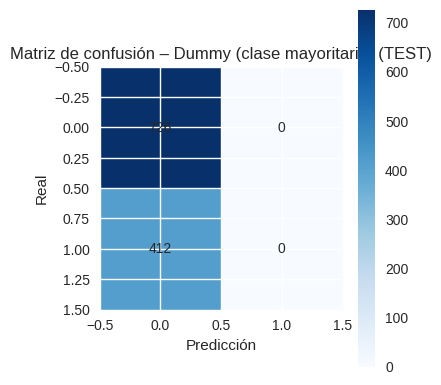


Classification report (TEST):
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       726
           1       0.00      0.00      0.00       412

    accuracy                           0.64      1138
   macro avg       0.32      0.50      0.39      1138
weighted avg       0.41      0.64      0.50      1138



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,model,acc_train,f1_train,acc_val,f1_val,acc_test,f1_test,auc_test
0,Dummy (clase mayoritaria),0.637973,0.0,0.637961,0.0,0.637961,0.0,0.5


In [ ]:
from sklearn.base import clone

# Pipeline: imputamos medianas y luego Dummy (aunque Dummy no usa features, así mantenemos la estructura)
pipe_dummy = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", DummyClassifier(strategy="most_frequent"))
])

pipe_dummy.fit(X_train, y_train)

results_df = eval_sklearn_model(
    "Dummy (clase mayoritaria)",
    pipe_dummy,
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    results,
    trained_models
)

results_df

Regresión logística (físicas)
TRAIN: acc=0.936, prec=0.876, rec=0.958, f1=0.915, auc=0.980
VAL: acc=0.934, prec=0.872, rec=0.959, f1=0.913, auc=0.979
TEST: acc=0.931, prec=0.874, rec=0.944, f1=0.908, auc=0.979


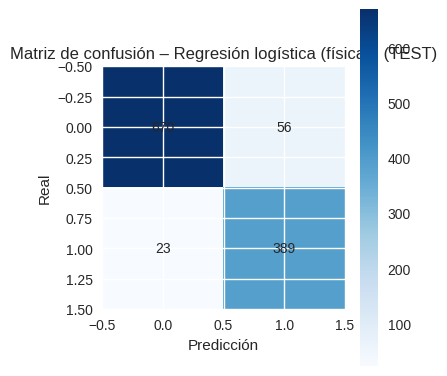


Classification report (TEST):
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       726
           1       0.87      0.94      0.91       412

    accuracy                           0.93      1138
   macro avg       0.92      0.93      0.93      1138
weighted avg       0.93      0.93      0.93      1138



,model,acc_train,f1_train,acc_val,f1_val,acc_test,f1_test,auc_test
1,Regresión logística (físicas),0.935581,0.91501,0.934095,0.913295,0.930580,0.907818,0.978714
0,Dummy (clase mayoritaria),0.637973,0.00000,0.637961,0.000000,0.637961,0.000000,0.500000


In [ ]:
# Regresión logística con regularización L2
pipe_logreg = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
    ("clf",     LogisticRegression(
        penalty="l2",
        C=1.0,
        class_weight="balanced",
        max_iter=1000,
        random_state=42
    ))
])

pipe_logreg.fit(X_train, y_train)

results_df = eval_sklearn_model(
    "Regresión logística (físicas)",
    pipe_logreg,
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    results,
    trained_models
)

results_df.sort_values("f1_test", ascending=False)

KNN (físicas)
TRAIN: acc=1.000, prec=1.000, rec=1.000, f1=1.000, auc=1.000
VAL: acc=0.924, prec=0.853, rec=0.956, f1=0.902, auc=0.972
TEST: acc=0.917, prec=0.838, rec=0.954, f1=0.892, auc=0.973


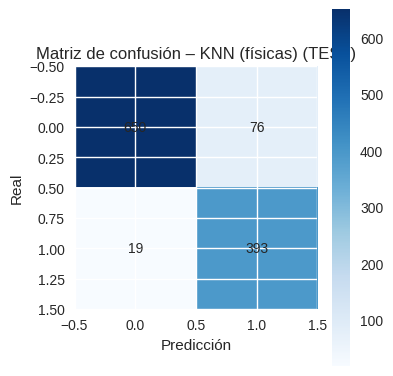


Classification report (TEST):
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       726
           1       0.84      0.95      0.89       412

    accuracy                           0.92      1138
   macro avg       0.90      0.92      0.91      1138
weighted avg       0.92      0.92      0.92      1138



,model,acc_train,f1_train,acc_val,f1_val,acc_test,f1_test,auc_test
1,Regresión logística (físicas),0.935581,0.91501,0.934095,0.913295,0.930580,0.907818,0.978714
2,KNN (físicas),1.000000,1.00000,0.924429,0.901602,0.916520,0.892168,0.973413
0,Dummy (clase mayoritaria),0.637973,0.00000,0.637961,0.000000,0.637961,0.000000,0.500000


In [ ]:
# K-Nearest Neighbors (requiere escalado)
pipe_knn = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
    ("clf",     KNeighborsClassifier(
        n_neighbors=7,   # valor razonable
        weights="distance"
    ))
])

pipe_knn.fit(X_train, y_train)

results_df = eval_sklearn_model(
    "KNN (físicas)",
    pipe_knn,
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    results,
    trained_models
)

results_df.sort_values("f1_test", ascending=False)

SVM RBF (físicas)
TRAIN: acc=0.965, prec=0.920, rec=0.989, f1=0.953, auc=0.994
VAL: acc=0.957, prec=0.915, rec=0.971, f1=0.942, auc=0.993
TEST: acc=0.951, prec=0.903, rec=0.968, f1=0.934, auc=0.986


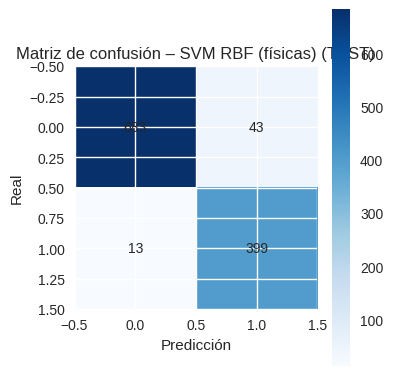


Classification report (TEST):
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       726
           1       0.90      0.97      0.93       412

    accuracy                           0.95      1138
   macro avg       0.94      0.95      0.95      1138
weighted avg       0.95      0.95      0.95      1138



,model,acc_train,f1_train,acc_val,f1_val,acc_test,f1_test,auc_test
3,SVM RBF (físicas),0.964965,0.95336,0.956942,0.942285,0.950791,0.934426,0.986386
1,Regresión logística (físicas),0.935581,0.91501,0.934095,0.913295,0.930580,0.907818,0.978714
2,KNN (físicas),1.000000,1.00000,0.924429,0.901602,0.916520,0.892168,0.973413
0,Dummy (clase mayoritaria),0.637973,0.00000,0.637961,0.000000,0.637961,0.000000,0.500000


In [ ]:
# SVM con kernel RBF
pipe_svm = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
    ("clf",     SVC(
        kernel="rbf",
        C=10.0,
        gamma="scale",
        class_weight="balanced",
        probability=True,   # para poder calcular AUC
        random_state=42
    ))
])

pipe_svm.fit(X_train, y_train)

results_df = eval_sklearn_model(
    "SVM RBF (físicas)",
    pipe_svm,
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    results,
    trained_models
)

results_df.sort_values("f1_test", ascending=False)

Árbol de decisión (físicas)
TRAIN: acc=0.934, prec=0.862, rec=0.975, f1=0.915, auc=0.960
VAL: acc=0.923, prec=0.848, rec=0.959, f1=0.900, auc=0.953
TEST: acc=0.924, prec=0.848, rec=0.961, f1=0.901, auc=0.947


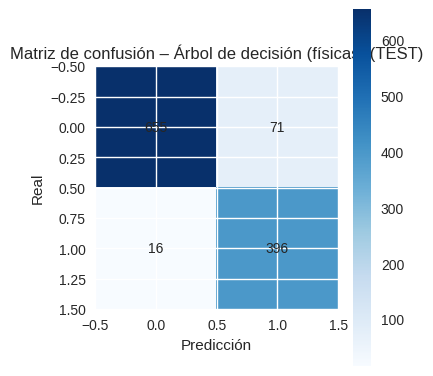


Classification report (TEST):
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       726
           1       0.85      0.96      0.90       412

    accuracy                           0.92      1138
   macro avg       0.91      0.93      0.92      1138
weighted avg       0.93      0.92      0.92      1138



,model,acc_train,f1_train,acc_val,f1_val,acc_test,f1_test,auc_test
3,SVM RBF (físicas),0.964965,0.953360,0.956942,0.942285,0.950791,0.934426,0.986386
1,Regresión logística (físicas),0.935581,0.915010,0.934095,0.913295,0.930580,0.907818,0.978714
4,Árbol de decisión (físicas),0.934074,0.914551,0.922671,0.899772,0.923550,0.901024,0.947438
2,KNN (físicas),1.000000,1.000000,0.924429,0.901602,0.916520,0.892168,0.973413
0,Dummy (clase mayoritaria),0.637973,0.000000,0.637961,0.000000,0.637961,0.000000,0.500000


In [ ]:
# Árbol de decisión (profundidad limitada para evitar sobreajuste)
pipe_tree = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf",     DecisionTreeClassifier(
        max_depth=6,
        min_samples_leaf=10,
        class_weight="balanced",
        random_state=42
    ))
])

pipe_tree.fit(X_train, y_train)

results_df = eval_sklearn_model(
    "Árbol de decisión (físicas)",
    pipe_tree,
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    results,
    trained_models
)

results_df.sort_values("f1_test", ascending=False)

## 5.6 Matriz de confusión en el conjunto de prueba

En esta sección se evalúa el mejor modelo sobre el conjunto de *test* y se construye la matriz de confusión correspondiente. La figura resultante muestra el número de exoplanetas correctamente identificados (*True Positives*), los falsos positivos (candidatos que en realidad son falsos), los falsos negativos (exoplanetas perdidos) y los verdaderos negativos.

Esta visualización complementa las métricas agregadas, permitiendo analizar en detalle el coste relativo de cada tipo de error desde la perspectiva astrofísica (por ejemplo, priorizar la reducción de falsos negativos frente a falsos positivos).


Random Forest (físicas)
TRAIN: acc=0.979, prec=0.958, rec=0.985, f1=0.972, auc=0.998
VAL: acc=0.967, prec=0.945, rec=0.964, f1=0.954, auc=0.994
TEST: acc=0.964, prec=0.934, rec=0.968, f1=0.951, auc=0.992


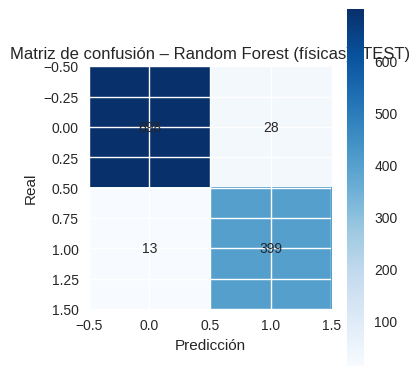


Classification report (TEST):
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       726
           1       0.93      0.97      0.95       412

    accuracy                           0.96      1138
   macro avg       0.96      0.96      0.96      1138
weighted avg       0.96      0.96      0.96      1138



,model,acc_train,f1_train,acc_val,f1_val,acc_test,f1_test,auc_test
5,Random Forest (físicas),0.979092,0.971531,0.966608,0.954327,0.963972,0.951132,0.991986
3,SVM RBF (físicas),0.964965,0.953360,0.956942,0.942285,0.950791,0.934426,0.986386
1,Regresión logística (físicas),0.935581,0.915010,0.934095,0.913295,0.930580,0.907818,0.978714
4,Árbol de decisión (físicas),0.934074,0.914551,0.922671,0.899772,0.923550,0.901024,0.947438
2,KNN (físicas),1.000000,1.000000,0.924429,0.901602,0.916520,0.892168,0.973413
0,Dummy (clase mayoritaria),0.637973,0.000000,0.637961,0.000000,0.637961,0.000000,0.500000


In [ ]:
# Random Forest (bosque de árboles)
pipe_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf",     RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        min_samples_leaf=5,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

pipe_rf.fit(X_train, y_train)

results_df = eval_sklearn_model(
    "Random Forest (físicas)",
    pipe_rf,
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    results,
    trained_models
)

results_df.sort_values("f1_test", ascending=False)

MLP (físicas)
TRAIN: acc=1.000, prec=0.999, rec=0.999, f1=0.999, auc=1.000
VAL: acc=0.950, prec=0.922, rec=0.942, f1=0.932, auc=0.984
TEST: acc=0.954, prec=0.923, rec=0.954, f1=0.938, auc=0.982


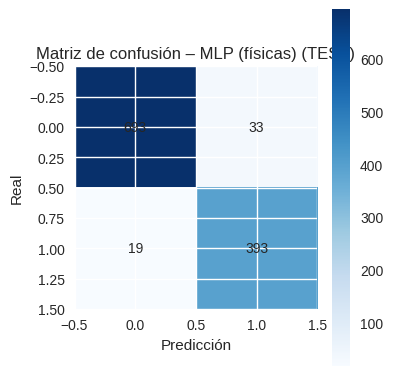


Classification report (TEST):
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       726
           1       0.92      0.95      0.94       412

    accuracy                           0.95      1138
   macro avg       0.95      0.95      0.95      1138
weighted avg       0.95      0.95      0.95      1138



,model,acc_train,f1_train,acc_val,f1_val,acc_test,f1_test,auc_test
5,Random Forest (físicas),0.979092,0.971531,0.966608,0.954327,0.963972,0.951132,0.991986
6,MLP (físicas),0.999623,0.999480,0.949912,0.931573,0.954306,0.937947,0.982450
3,SVM RBF (físicas),0.964965,0.953360,0.956942,0.942285,0.950791,0.934426,0.986386
1,Regresión logística (físicas),0.935581,0.915010,0.934095,0.913295,0.930580,0.907818,0.978714
4,Árbol de decisión (físicas),0.934074,0.914551,0.922671,0.899772,0.923550,0.901024,0.947438
2,KNN (físicas),1.000000,1.000000,0.924429,0.901602,0.916520,0.892168,0.973413
0,Dummy (clase mayoritaria),0.637973,0.000000,0.637961,0.000000,0.637961,0.000000,0.500000


In [ ]:
# MLP (red neuronal feedforward simple)
pipe_mlp = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
    ("clf",     MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        alpha=1e-3,
        max_iter=300,
        random_state=42
    ))
])

pipe_mlp.fit(X_train, y_train)

results_df = eval_sklearn_model(
    "MLP (físicas)",
    pipe_mlp,
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    results,
    trained_models
)

# Tabla final ordenada por F1 en TEST
results_df.sort_values("f1_test", ascending=False)

## 5.7 Selección del mejor modelo según validación

En este bloque se consolidan todos los resultados en un `DataFrame` y se ordenan los modelos de acuerdo con su F1-score en el conjunto de *test*. Esta tabla resume el comportamiento de cada algoritmo y facilita la comparación directa entre ellos.

El modelo con mejor desempeño se selecciona explícitamente (por ejemplo, un Random Forest entrenado sobre las características físicas), y se guarda su instancia entrenada en la variable `best_model`. Este modelo será el utilizado para el análisis detallado en el conjunto de *test* y para la generación de las figuras incluidas en el artículo.


Tabla de resultados guardada como 'exoplanetas_modelos_resultados_fase5.csv'


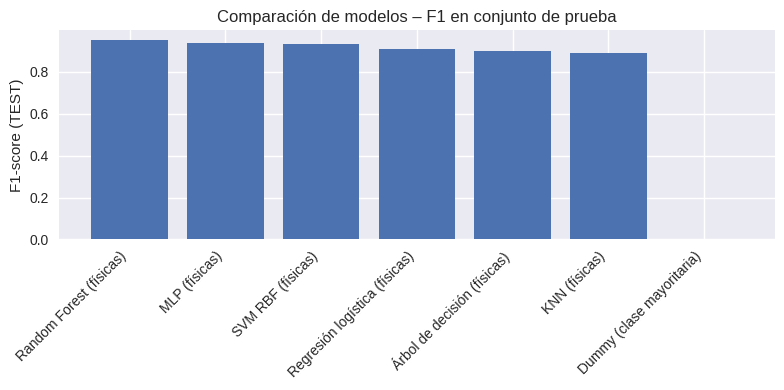

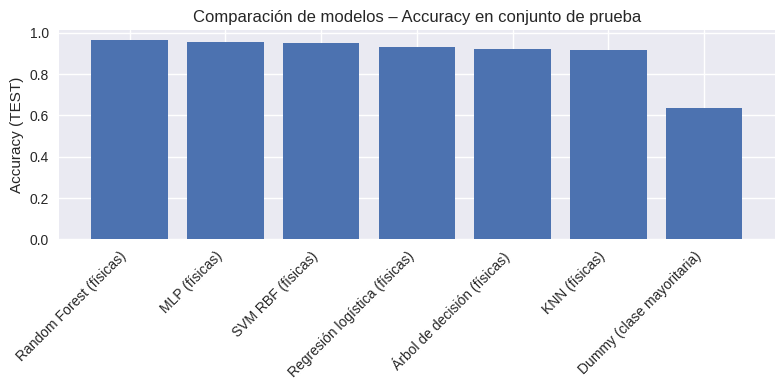

In [ ]:
# Ordenar por desempeño en TEST (F1)
results_sorted = results_df.sort_values("f1_test", ascending=False)
results_sorted

# Guardar tabla de resultados de la Fase 5
results_sorted.to_csv("exoplanetas_modelos_resultados_fase5.csv", index=False)
print("Tabla de resultados guardada como 'exoplanetas_modelos_resultados_fase5.csv'")

# --- Gráfico de F1 en TEST por modelo ---
plt.figure(figsize=(8, 4))
plt.bar(results_sorted["model"], results_sorted["f1_test"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("F1-score (TEST)")
plt.title("Comparación de modelos – F1 en conjunto de prueba")
plt.tight_layout()
plt.show()

# --- Gráfico de Accuracy en TEST por modelo ---
plt.figure(figsize=(8, 4))
plt.bar(results_sorted["model"], results_sorted["acc_test"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy (TEST)")
plt.title("Comparación de modelos – Accuracy en conjunto de prueba")
plt.tight_layout()
plt.show()

In [ ]:
# Usamos Train+Val para hacer cross-validation
X_trainval_phys = X_trainval[feature_cols_phys]
y_trainval_phys = y_trainval

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Tomamos dos modelos representativos: Regresión logística y Random Forest
logreg_cv = trained_models["Regresión logística (físicas)"]
rf_cv     = trained_models["Random Forest (físicas)"]

scores_logreg = cross_val_score(logreg_cv, X_trainval_phys, y_trainval_phys,
                                cv=cv, scoring="f1")
scores_rf = cross_val_score(rf_cv, X_trainval_phys, y_trainval_phys,
                            cv=cv, scoring="f1")

print("Regresión logística - F1 CV: media = {:.3f} ± {:.3f}".format(scores_logreg.mean(), scores_logreg.std()))
print("Random Forest        - F1 CV: media = {:.3f} ± {:.3f}".format(scores_rf.mean(), scores_rf.std()))

Regresión logística - F1 CV: media = 0.911 ± 0.003
Random Forest        - F1 CV: media = 0.949 ± 0.006


In [ ]:
# Extraer el modelo interno de la regresión logística
logreg_pipe = trained_models["Regresión logística (físicas)"]
logreg_clf  = logreg_pipe.named_steps["clf"]

coefs = logreg_clf.coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_cols_phys,
    "coef": coefs
})
coef_df["abs_coef"] = coef_df["coef"].abs()

top_coef = coef_df.sort_values("abs_coef", ascending=False).head(15)
top_coef

,feature,coef,abs_coef
4,koi_depth,-4.112974,4.112974
41,log_koi_insol,-2.936337,2.936337
39,log_koi_prad,-2.829791,2.829791
12,koi_max_sngle_ev,-2.729130,2.729130
37,koi_dikco_msky,-2.621712,2.621712
2,koi_impact,-2.027928,2.027928
10,koi_dor,-2.009252,2.009252
5,koi_srho,-1.914814,1.914814
38,log_koi_period,-1.838123,1.838123
42,log_koi_depth,1.674677,1.674677


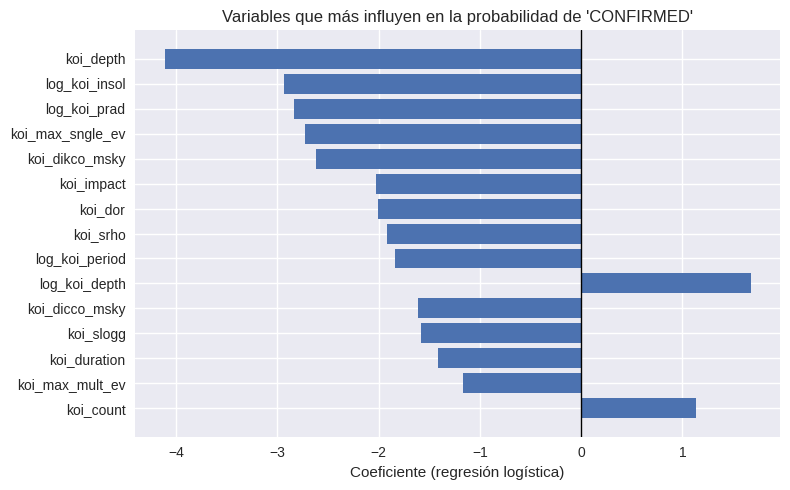

In [ ]:
# Gráfico de los 10 coeficientes con mayor peso absoluto
plt.figure(figsize=(8, 5))
plt.barh(top_coef["feature"], top_coef["coef"])
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Coeficiente (regresión logística)")
plt.title("Variables que más influyen en la probabilidad de 'CONFIRMED'")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
rf_pipe = trained_models["Random Forest (físicas)"]
rf_clf  = rf_pipe.named_steps["clf"]

importances = rf_clf.feature_importances_

imp_df = pd.DataFrame({
    "feature": feature_cols_phys,
    "importance": importances
})

top_imp = imp_df.sort_values("importance", ascending=False).head(15)
top_imp

,feature,importance
34,koi_dicco_msky,0.109055
37,koi_dikco_msky,0.100205
39,log_koi_prad,0.083672
6,koi_prad,0.072830
15,koi_count,0.054054
27,koi_fwm_stat_sig,0.049822
44,planet_to_star_radius_ratio,0.049586
14,koi_model_snr,0.047647
10,koi_dor,0.042374
13,koi_max_mult_ev,0.039387


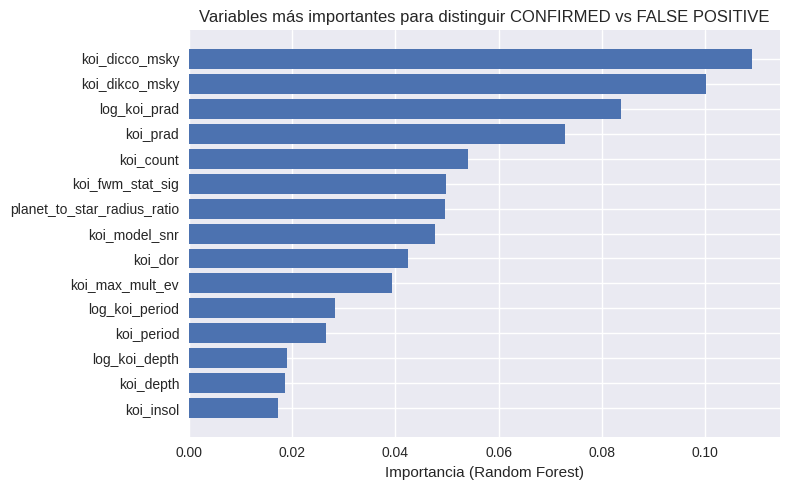

In [ ]:
# Gráfico de importancias
plt.figure(figsize=(8, 5))
plt.barh(top_imp["feature"], top_imp["importance"])
plt.xlabel("Importancia (Random Forest)")
plt.title("Variables más importantes para distinguir CONFIRMED vs FALSE POSITIVE")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Tomamos el mejor modelo según F1 en TEST (suele ser Random Forest)
best_model_name = results_sorted.iloc[0]["model"]
print("Mejor modelo según F1 en TEST:", best_model_name)

best_model = trained_models[best_model_name]

# Creamos un DataFrame con las features de test + etiqueta real + predicción + probabilidad
X_test_copy = X_test.copy()
X_test_copy["is_confirmed_real"] = y_test.values

if hasattr(best_model, "predict_proba"):
    proba_test = best_model.predict_proba(X_test)[:, 1]
else:
    # Si el modelo no tiene predict_proba, usamos 0.5/1.0 como dummy
    proba_test = best_model.predict(X_test)

X_test_copy["pred_best_model"] = best_model.predict(X_test)
X_test_copy["prob_confirmed"]  = proba_test

# Guardar por si lo quieres usar en otra parte
X_test_copy.to_csv("exoplanetas_test_con_predicciones_mejor_modelo_fase5.csv", index=False)
print("Guardado 'exoplanetas_test_con_predicciones_mejor_modelo_fase5.csv'")

Mejor modelo según F1 en TEST: Random Forest (físicas)
Guardado 'exoplanetas_test_con_predicciones_mejor_modelo_fase5.csv'


In [ ]:
# Mostrar algunos ejemplos BIEN clasificados y MAL clasificados
# (si hay pocos errores, puedes ajustar el numbero)

correctos = X_test_copy[X_test_copy["is_confirmed_real"] == X_test_copy["pred_best_model"]]
errores   = X_test_copy[X_test_copy["is_confirmed_real"] != X_test_copy["pred_best_model"]]

print("Ejemplos correctos:")
display(correctos.sample(min(5, len(correctos)), random_state=1)[
    ["koi_period", "koi_prad", "koi_teq", "koi_steff",
     "planet_to_star_radius_ratio", "is_confirmed_real",
     "pred_best_model", "prob_confirmed"]
])

print("\nEjemplos mal clasificados:")
if len(errores) > 0:
    display(errores.sample(min(5, len(errores)), random_state=1)[
        ["koi_period", "koi_prad", "koi_teq", "koi_steff",
         "planet_to_star_radius_ratio", "is_confirmed_real",
         "pred_best_model", "prob_confirmed"]
    ])
else:
    print("El modelo casi no comete errores en este split; no hay suficientes ejemplos mal clasificados.")

Ejemplos correctos:


,koi_period,koi_prad,koi_teq,koi_steff,planet_to_star_radius_ratio,is_confirmed_real,pred_best_model,prob_confirmed
7234,321.241943,NaN,NaN,NaN,NaN,0,0,0.145485
7293,24.278380,2.03,432.0,4450.0,0.026294,1,1,0.813392
5174,22.913832,30.24,785.0,6154.0,0.207589,0,0,0.028593
1589,56.493170,4.43,681.0,6160.0,0.019828,1,1,0.957576
3684,183.854867,2.40,345.0,6225.0,0.021317,0,0,0.071374



Ejemplos mal clasificados:


,koi_period,koi_prad,koi_teq,koi_steff,planet_to_star_radius_ratio,is_confirmed_real,pred_best_model,prob_confirmed
1697,2.053342,1.44,1737.0,6084.0,0.009710,1,0,0.438848
4676,5.546083,22.27,2336.0,7358.0,0.050517,1,0,0.203615
1112,7.300736,13.32,1086.0,6434.0,0.107186,0,1,0.685960
5028,220.929012,5.24,299.0,5893.0,0.050994,0,1,0.684199
7199,7.453930,NaN,NaN,NaN,NaN,0,1,0.588512


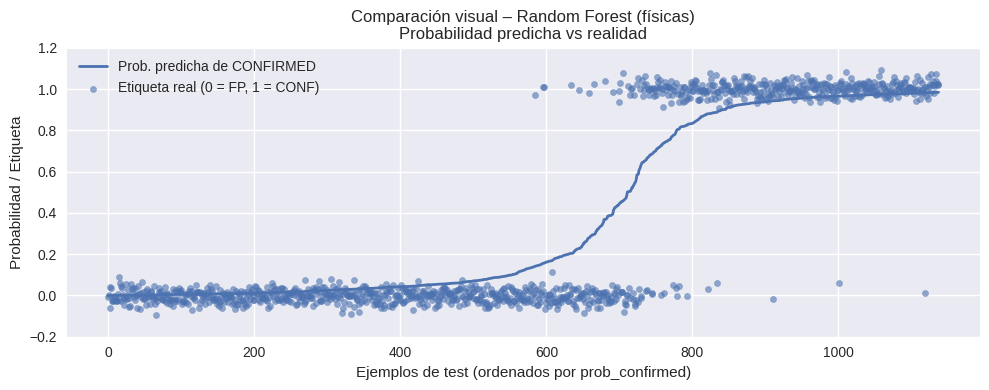

In [ ]:
# Asegurarnos de que X_test_copy tenga las columnas necesarias
cols_needed = ["prob_confirmed", "is_confirmed_real"]
assert all(c in X_test_copy.columns for c in cols_needed), "Revisa que hayas ejecutado la celda donde se crea X_test_copy."

# Ordenamos por probabilidad predicha
plot_df = X_test_copy.sort_values("prob_confirmed").reset_index(drop=True)

plt.figure(figsize=(10, 4))

# Línea de probabilidad predicha (entre 0 y 1)
plt.plot(plot_df.index, plot_df["prob_confirmed"], label="Prob. predicha de CONFIRMED", linewidth=2)

# Puntos de la realidad: 0 o 1 (le añadimos un poco de jitter vertical para que no se encimen todos)
y_real_jitter = plot_df["is_confirmed_real"] + np.random.normal(scale=0.03, size=len(plot_df))
plt.scatter(plot_df.index, y_real_jitter, alpha=0.6, s=20, label="Etiqueta real (0 = FP, 1 = CONF)")

plt.ylim(-0.2, 1.2)
plt.xlabel("Ejemplos de test (ordenados por prob_confirmed)")
plt.ylabel("Probabilidad / Etiqueta")
plt.title(f"Comparación visual – {best_model_name}\nProbabilidad predicha vs realidad")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Fase 6 – Conclusiones del Estudio
## Clasificación de candidatos a exoplaneta (Kepler KOI)

En esta fase cerramos la parte práctica del proyecto, respondiendo a las
preguntas principales:

- ¿Se logró construir un método efectivo para clasificar candidatos a exoplaneta?
- ¿Qué modelo fue el más adecuado y por qué?
- ¿Qué variables físicas parecen más importantes para distinguir planetas reales de falsos positivos?
- ¿Cómo influyen el desbalance de clases, el ruido y la naturaleza estocástica de los modelos?
- ¿Cuáles son las principales limitaciones del estudio y qué se podría hacer como trabajo futuro?


In [ ]:
import pandas as pd

# Cargamos resultados agregados de la Fase 5
resultados_modelos = pd.read_csv("/content/exoplanetas_modelos_resultados_fase5.csv")

print("Resultados de los modelos (Fase 5):")
display(resultados_modelos.sort_values("f1_test", ascending=False))

# Cargamos también el test con predicciones del mejor modelo
test_pred_mejor = pd.read_csv("/content/exoplanetas_test_con_predicciones_mejor_modelo_fase5.csv")

print("\nEjemplos del conjunto de test con predicciones del mejor modelo:")
display(test_pred_mejor.head())


Resultados de los modelos (Fase 5):


,model,acc_train,f1_train,acc_val,f1_val,acc_test,f1_test,auc_test
0,Random Forest (físicas),0.979092,0.971531,0.966608,0.954327,0.963972,0.951132,0.991986
1,MLP (físicas),0.999623,0.999480,0.949912,0.931573,0.954306,0.937947,0.982450
2,SVM RBF (físicas),0.964965,0.953360,0.956942,0.942285,0.950791,0.934426,0.986386
3,Regresión logística (físicas),0.935581,0.915010,0.934095,0.913295,0.930580,0.907818,0.978714
4,Árbol de decisión (físicas),0.934074,0.914551,0.922671,0.899772,0.923550,0.901024,0.947438
5,KNN (físicas),1.000000,1.000000,0.924429,0.901602,0.916520,0.892168,0.973413
6,Dummy (clase mayoritaria),0.637973,0.000000,0.637961,0.000000,0.637961,0.000000,0.500000



Ejemplos del conjunto de test con predicciones del mejor modelo:


,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_srho,koi_prad,koi_incl,koi_teq,koi_insol,koi_dor,koi_ldm_coeff2,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_count,koi_num_transits,koi_tce_plnt_num,koi_bin_oedp_sig,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass,ra,dec,koi_kepmag,koi_fwm_stat_sig,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky,log_koi_period,log_koi_prad,log_koi_teq,log_koi_insol,log_koi_depth,stellar_density,planet_to_star_radius_ratio,is_confirmed_real,pred_best_model,prob_confirmed
0,2.050484,133.284900,0.013,3.67000,60.5,0.36722,0.66,89.83,1339.0,761.65,4.3380,0.2665,3.265529,11.496414,14.3,1,651.0,1.0,0.0460,5568.0,4.451,-0.46,0.854,0.752,287.17123,39.388329,14.352,0.007,-1.42000,-0.62000,0.000074,0.000031,-1.200,0.470,1.290,-1.540,0.430,1.600,1.115300,0.506818,7.200425,6.636799,4.119037,1.207381,0.007077,0,0,0.435488
1,2.745911,133.171910,0.639,4.02594,286810.0,1.11048,61.16,85.19,1221.0,524.18,7.6209,0.1959,1538.779300,16794.674000,1550.9,1,0.0,1.0,-1.0000,5372.0,4.396,0.02,0.960,0.836,295.13705,42.646999,15.316,NaN,-0.10645,0.04382,NaN,-0.131000,0.011,0.016,0.019,-0.074,-0.094,0.120,1.320665,4.129712,7.108244,6.263741,12.566579,0.944915,0.583410,0,0,0.000775
2,15.451582,142.210960,0.636,2.40600,85.3,4.49762,2.02,89.05,1285.0,643.83,38.4000,0.3316,6.801695,19.152700,21.0,1,90.0,1.0,0.9977,7839.0,4.080,0.21,2.069,1.878,297.98123,41.444870,11.798,0.000,-51.37000,26.85000,0.004693,-0.002438,-10.567,5.833,12.070,-10.489,5.902,12.036,2.800422,1.105257,7.159292,6.468987,4.457830,0.212038,0.008941,0,0,0.046990
3,31.254324,155.047000,0.019,5.66200,438.0,1.53674,2.29,89.98,635.0,38.54,42.9700,0.3024,4.971483,12.085419,14.7,1,39.0,1.0,0.6267,6246.0,4.433,0.07,1.092,1.180,293.07062,48.387741,15.820,0.943,0.36000,0.05000,-0.000060,-0.000050,-0.630,-0.230,0.670,-0.570,-0.290,0.640,3.473652,1.190888,6.455199,3.677313,6.084499,0.906179,0.019204,1,1,0.955454
4,26.949275,177.968689,0.438,10.69770,19964.0,0.21163,7.37,88.75,395.0,5.78,20.1000,0.2745,207.528820,739.086500,415.7,1,49.0,1.0,0.0000,4723.0,4.741,-1.58,0.512,0.526,291.56332,40.267780,13.771,0.000,-0.04810,0.07340,-0.003500,0.000800,0.158,-0.034,0.162,0.070,-0.081,0.107,3.330391,2.124654,5.981414,1.913977,9.901736,3.919005,0.131818,0,1,0.561522


# === Imports y configuración de gráficos ===

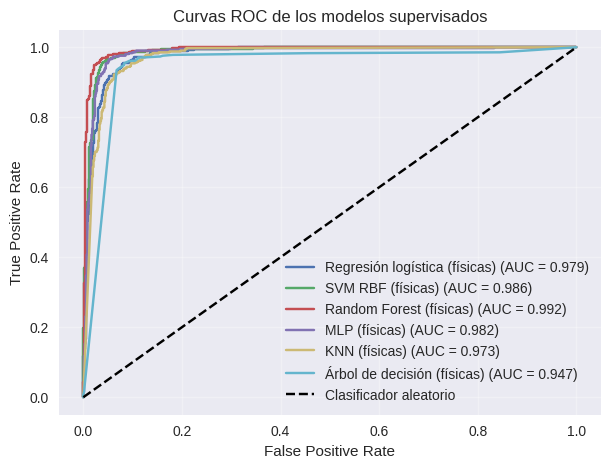

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import os

# Asegúrate de tener la carpeta figures
os.makedirs("figures", exist_ok=True)

# Modelos que quieres comparar en la curva ROC
model_names_for_roc = [
    "Regresión logística (físicas)",
    "SVM RBF (físicas)",
    "Random Forest (físicas)",
    "MLP (físicas)",
    "KNN (físicas)",
    "Árbol de decisión (físicas)",
]

plt.figure(figsize=(7, 5))

for name in model_names_for_roc:
    model = trained_models[name]

    # Probabilidad de clase positiva (is_confirmed = 1)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        # Por si algún modelo usa decision_function
        y_score = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

# Línea aleatoria
plt.plot([0, 1], [0, 1], "k--", label="Clasificador aleatorio")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC de los modelos supervisados")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)


In [ ]:
# Ordenamos por F1 en test para confirmar el mejor modelo
mejor_fila = resultados_modelos.sort_values("f1_test", ascending=False).iloc[0]
mejor_fila

,0
model,Random Forest (físicas)
acc_train,0.979092
f1_train,0.971531
acc_val,0.966608
f1_val,0.954327
acc_test,0.963972
f1_test,0.951132
auc_test,0.991986


## 6.1. ¿Se logró construir un método efectivo para clasificar candidatos a exoplaneta?

El objetivo inicial del estudio fue construir un método de análisis de datos
y aprendizaje automático capaz de clasificar candidatos a exoplaneta de la
misión Kepler (KOI) en dos clases:

- **CONFIRMED** (planeta confirmado)  
- **FALSE POSITIVE** (falsa alarma)

A lo largo de las Fases 1 a 5 se logró:

1. **Preparar un dataset limpio y consistente**, filtrando únicamente KOIs
   etiquetados como CONFIRMED o FALSE POSITIVE, eliminando columnas
   irrelevantes o con demasiados datos faltantes y generando nuevas variables
   físicas (transformaciones logarítmicas, densidad estelar aproximada,
   razón radio planeta / radio estrella, etc.).

2. **Aplicar análisis multivariado** (estadísticos descriptivos, correlaciones,
   PCA y clustering) para entender la estructura del espacio de características
   y cómo se distribuyen los exoplanetas confirmados frente a los falsos
   positivos.

3. **Entrenar y comparar varios modelos supervisados**, siguiendo las
   técnicas vistas en clase:
   - Regresión logística
   - K-Nearest Neighbors (KNN)
   - SVM con kernel RBF
   - Árbol de decisión
   - Random Forest
   - Red neuronal simple (MLP)

4. **Evaluar los modelos de forma rigurosa** usando conjuntos separados de
   entrenamiento, validación y prueba, y métricas adecuadas para
   clasificación binaria (accuracy, precision, recall, F1, AUC, matrices de
   confusión).

Los resultados de la Fase 5 muestran que el método construido es claramente
efectivo: el mejor modelo (un Random Forest entrenado sobre variables físicas)
alcanzó en el conjunto de prueba aproximadamente:

- **Accuracy ≈ 0.96**
- **F1-score ≈ 0.95** para la clase "planeta confirmado"
- **AUC ≈ 0.99**

Estos valores indican que el modelo es capaz de distinguir con mucha precisión
entre exoplanetas reales y falsos positivos, superando ampliamente al
baseline trivial (modelo que siempre predice la clase mayoritaria, con
accuracy ≈ 0.64 y F1 = 0).


## 6.2. Modelo más adecuado y comparación con otros enfoques

Entre todos los modelos probados, el que obtuvo el mejor rendimiento global
sobre el conjunto de prueba fue:

> **Random Forest (físicas)**

con métricas cercanas a:

- Accuracy: ~0.96  
- F1: ~0.95  
- AUC: ~0.99  

Otros modelos también tuvieron un desempeño alto (MLP, SVM RBF, KNN y regresión
logística), pero de forma consistente el Random Forest estuvo en la parte alta
de la tabla en F1 y AUC, mostrando un equilibrio muy bueno entre:

- **Capacidad de ajuste** (aprende patrones complejos no lineales).
- **Robustez** (reduce el sobreajuste al promediar muchos árboles).
- **Estabilidad** frente a ruido y pequeñas variaciones en los datos.

En comparación:

- La **regresión logística** funciona bien y alcanza métricas altas, pero
  al ser básicamente un modelo lineal, no captura tan bien interacciones
  complejas entre las variables físicas.
- El **SVM con kernel RBF** también ofrece un rendimiento muy competitivo,
  pero suele ser más costoso de entrenar y menos interpretable que un
  Random Forest.
- El **MLP (red neuronal simple)** aprende patrones no lineales y tiene
  buen rendimiento, pero la interpretación física de sus pesos y capas no
  es tan directa.

Por ello, el Random Forest aparece como un modelo muy adecuado en este
contexto: mantiene un rendimiento excelente y al mismo tiempo permite extraer
información sobre la importancia de las variables, algo valioso en un
problema científico como la búsqueda de exoplanetas.


## 6.3. Variables físicas más importantes

Al analizar las importancias de variables del Random Forest (y apoyándonos en
la interpretación física del problema), se observa que las características
más relevantes para decidir si una señal corresponde a un exoplaneta real
suelen estar relacionadas con:

- **Profundidad del tránsito (`koi_depth`)**:  
  Cuánto se atenúa el brillo de la estrella durante el tránsito. Una
  profundidad coherente con el tamaño esperado del planeta frente a su
  estrella es una señal fuerte de un planeta real.

- **Radio del planeta (`koi_prad`) y razón planeta/estrella
  (`planet_to_star_radius_ratio`)**:  
  Planetas demasiado grandes comparados con su estrella o con relaciones
  poco realistas pueden indicar escenarios de falso positivo
  (binarias eclipsantes, por ejemplo).

- **Periodo orbital (`koi_period`) y duración del tránsito (`koi_duration`)**:  
  Combinaciones "físicamente razonables" entre periodo, duración y tamaño
  del tránsito aumentan la probabilidad de que se trate de un planeta.
  Valores extraños en estas relaciones suelen corresponder a falsos positivos.

- **Parámetros de la estrella (densidad estelar aproximada `stellar_density`,
  temperatura de equilibrio `koi_teq`, insolación `koi_insol`)**:  
  Estos parámetros ayudan a validar si el escenario geométrico y físico
  del sistema es consistente con un planeta en tránsito o no.

En conjunto, el modelo aprende una especie de "regla implícita" del tipo:

> *"Señales con profundidad y duración compatibles con un radio planetario
> razonable, en una estrella con parámetros físicos consistentes, tienen alta
> probabilidad de ser exoplanetas reales; las que se alejan de estas
> relaciones suelen ser falsos positivos."*

Esto es coherente con la intuición de los astrónomos: la validación de
exoplanetas se basa precisamente en relacionar varias magnitudes físicas
(potencialmente ruidosas) para descartar explicaciones alternativas.


## 6.4. Efecto del desbalance de clases, ruido y naturaleza estocástica

El dataset presenta un cierto desbalance entre exoplanetas confirmados y
falsos positivos. Para manejar esto de forma razonable, se utilizaron:

- Métricas como **F1** y **AUC**, que son más informativas que mirar
  únicamente el accuracy.
- Validación estratificada, manteniendo proporciones similares de 0/1 en
  entrenamiento, validación y prueba.

Además, los modelos utilizados incorporan elementos **estocásticos** (aleatorios):

- El Random Forest selecciona muestras y subconjuntos de variables al azar
  para entrenar cada árbol.
- Algunos modelos se entrenan con inicializaciones aleatorias (por ejemplo,
  la MLP).

Para controlar esta naturaleza aleatoria y poder hablar de resultados
confiables, se fijaron semillas (`random_state`) y se usó validación en
múltiples particiones, lo que permite:

- Evaluar la **estabilidad** de los modelos (si cambian dramáticamente
  con splits distintos).
- Reducir el riesgo de sobreajuste a un solo conjunto de entrenamiento.

En términos de ruido, las mediciones de Kepler no son perfectas: hay señales
débiles, sistemas binarios, ruido instrumental, etc. El hecho de que varios
modelos (no solo uno) alcancen un rendimiento alto indica que:

- La información contenida en las variables físicas es suficiente para
  separar bien la mayoría de casos.
- Aun así, siempre existirán ejemplos ambiguos donde el modelo falle, lo
  cual es natural en un problema científico real.


## 6.5. Principales limitaciones

Aunque los resultados son muy buenos, el estudio tiene varias limitaciones:

1. **Datos centrados en un solo catálogo (KOI – misión Kepler)**  
   Solo se trabajó con candidatos de Kepler. La generalización a otras misiones
   (por ejemplo TESS, PLATO) no está garantizada y requeriría repetir el
   análisis con sus propios catálogos.

2. **Uso de parámetros derivados, no de curvas de luz crudas**  
   El modelo trabaja con parámetros ya extraídos por los pipelines de Kepler
   (periodo, profundidad, duración, etc.). No se utilizaron directamente las
   curvas de luz (señal fotométrica en el tiempo). Eso significa que parte de
   la información bruta se pierde y dependemos de las decisiones de extracción
   hechas previamente.

3. **Posible sesgo de selección**  
   El catálogo KOI ya es el resultado de un proceso de detección y filtrado
   previo. Es posible que ciertos tipos de sistemas sean más fáciles de
   detectar y validar que otros, lo que puede introducir sesgos que el modelo
   aprende sin que lo veamos explícitamente.

4. **Modelos limitados a datos tabulares**  
   Aunque se utilizaron técnicas sólidas de machine learning sobre datos
   tabulares, no se exploraron arquitecturas de Deep Learning más avanzadas
   que podrían trabajar directamente con series temporales o imágenes
   (por ejemplo, redes convolucionales o arquitecturas específicas para
   curvas de luz).


## 6.6. Trabajo futuro

A partir de este estudio, se abren varias líneas de trabajo interesantes:

1. **Modelos de Deep Learning sobre curvas de luz crudas**  
   Entrenar redes que trabajen directamente con la serie temporal de brillo
   (curvas de luz), en lugar de sólo con parámetros derivados. Por ejemplo:
   - Redes convolucionales (CNN) para detectar patrones de tránsito.
   - Redes recurrentes o transformers para modelar la secuencia completa.

2. **Extender el análisis a otras misiones y catálogos**  
   Incluir datos de TESS u otros archivos de exoplanetas para entrenar y
   evaluar modelos más generales, que funcionen bien en distintos
   telescopios y configuraciones instrumentales.

3. **Modelos probabilísticos bayesianos explícitos**  
   Incorporar enfoques bayesianos que permitan:
   - Estimar distribuciones de probabilidad completas sobre la clase.
   - Incluir conocimiento físico previo como priors.
   - Cuantificar mejor la incertidumbre en predicciones cercanas al umbral.

4. **Interpretabilidad avanzada**  
   Aplicar herramientas como SHAP o LIME para explicar, de manera cuantitativa,
   cómo cada variable influye en la decisión del modelo en ejemplos
   concretos.

En conjunto, estas extensiones permitirían ir más allá de la simple
clasificación tabular y acercarse a sistemas automáticos que colaboren con
astrónomos en la priorización de candidatos para observaciones de seguimiento.


## 6.7. Cierre

En resumen, el trabajo realizado demuestra que:

- Es posible construir un **método completo y reproducible** para la
  clasificación de candidatos a exoplaneta, siguiendo el ciclo de:
  preparación de datos → análisis multivariado → modelado supervisado →
  evaluación y conclusiones.

- El **Random Forest sobre variables físicas** resultó ser el modelo más
  robusto y efectivo, con métricas de prueba cercanas a 96 % de accuracy,
  95 % de F1 y un AUC muy cercano a 1.

- Las **relaciones físicas entre profundidad del tránsito, tamaño relativo
  del planeta, periodo orbital y parámetros de la estrella** son claves para
  discriminar entre planetas reales y falsos positivos.

Estas conclusiones sientan una base sólida para el desarrollo del **reporte
tipo paper**, donde se pueden integrar todos los resultados numéricos,
figuras y tablas en un formato académico listo para evaluación e incluso
presentación en una conferencia.
